In [18]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import nltk
import re
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

In [19]:
df = pd.read_csv("./Airplane_Crashes_and_Fatalities_Since_1908.csv")
df.head()
df = df[['Summary', 'Fatalities']]

# Preprocessing
df = df.drop_duplicates()
df = df.dropna(subset=['Summary', 'Fatalities'])
df['Summary'] = df['Summary'].str.lower()  # Convert to lowercase
df['Summary'] = df['Summary'].str.replace(r'[^\w\s]', '')  # Remove punctuation

# Tokenize
stop_words = set(stopwords.words('english'))
stop_words.update(['plane', 'aircraft', 'flight','crashed','en','route','sea','miles','ft','000','500','200','mt'])  # Add additional words to remove
df['Summary'] = df['Summary'].apply(lambda x: ' '.join([word for word in word_tokenize(x) if word not in stop_words]))

print(df.head()) #check if everything's okay

                                             Summary  Fatalities
0  demonstration , u.s. army flyer flown orville ...         1.0
1  first u.s. dirigible akron exploded offshore a...         5.0
2  first fatal airplane accident canada occurred ...         1.0
3  airship flew thunderstorm encountered severe d...        14.0
4  hydrogen gas vented sucked forward engine igni...        30.0


In [20]:
#dividing data into before 1950 and after 1950

df = pd.read_csv("./Airplane_Crashes_and_Fatalities_Since_1908.csv")
df['Date'] = pd.to_datetime(df['Date'])

start_year = 1908
end_year = 2008
year_range = 50 

df_list = [] #in case we want to divide them into smaller range

end_date_war = pd.to_datetime(f'31/12/1950', format='%d/%m/%Y')
df_prewar = df[(df['Date']<= end_date_war)]
df_postwar = df[(df['Date']> end_date_war)]

for year in range(start_year, end_year, year_range):
    start_date = pd.to_datetime(f'01/01/{year}', format='%d/%m/%Y')
    end_date = pd.to_datetime(f'31/12/{year+year_range-1}', format='%d/%m/%Y')
    filtered_df = df[(df['Date'] >= start_date) & (df['Date'] <= end_date)]
    df_list.append(filtered_df)

In [21]:
df = df[['Summary', 'Fatalities']]
df = df.drop_duplicates()
df = df.dropna(subset=['Summary', 'Fatalities'])

df['Summary'] = df['Summary'].str.lower()  # Convert to lowercase
df['Summary'] = df['Summary'].str.replace(r'[^\w\s]', '')  # Remove punctuation

stop_words = set(stopwords.words('english'))
stop_words.update(['plane', 'aircraft', 'flight','crashed','en','route','sea','miles','ft','000','500','200','mt'])  # Add additional words to remove
df['Summary'] = df['Summary'].apply(lambda x: ' '.join([word for word in word_tokenize(x) if word not in stop_words]))

print(df.head())

                                             Summary  Fatalities
0  demonstration , u.s. army flyer flown orville ...         1.0
1  first u.s. dirigible akron exploded offshore a...         5.0
2  first fatal airplane accident canada occurred ...         1.0
3  airship flew thunderstorm encountered severe d...        14.0
4  hydrogen gas vented sucked forward engine igni...        30.0


In [22]:
df['Summary'] = df['Summary'].fillna('') #filling missing data

#extracting features
vectorizer = TfidfVectorizer()
features = vectorizer.fit_transform(df['Summary'])
features_df = pd.DataFrame(
    features.toarray(),
    columns=vectorizer.get_feature_names_out(),
    index=df.index
)
print(features_df)

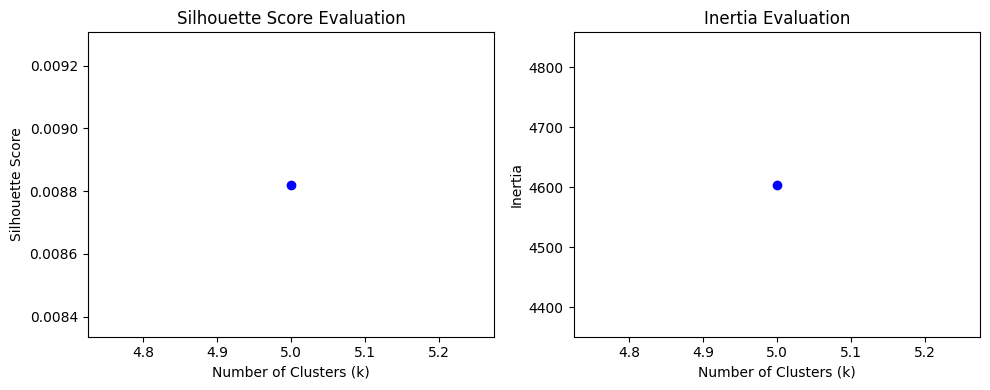

In [23]:
# Finding the optimal value for k in Kmeans
#Computing Silhouette and Inertia Score


k_values = range(5, 100) #k values from 5 to 100

silhouette_scores = []
inertia_scores = []

#performing clustering for each value
for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(features)
    labels = kmeans.labels_
    
    silhouette = silhouette_score(features, labels)
    silhouette_scores.append(silhouette)
    inertia_scores.append(kmeans.inertia_)

plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(k_values, silhouette_scores, 'bo-')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Score Evaluation')

plt.subplot(1, 2, 2)
plt.plot(k_values, inertia_scores, 'bo-')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Inertia')
plt.title('Inertia Evaluation')

plt.tight_layout()
plt.show()

Label: shot, air, fire, pilot, killed, Count: 2064
Label: approach, pilot, terrain, altitude, ground, Count: 825
Label: engine, failure, landing, fire, emergency, Count: 502
Label: runway, short, approach, landing, overran, Count: 368
Label: taking, shortly, minutes, engine, airport, Count: 227
Label: attempting, land, landing, runway, struck, Count: 215
Label: conditions, weather, vfr, adverse, continued, Count: 178
Label: takeoff, engine, shortly, failure, runway, Count: 153
Label: turbulence, thunderstorm, severe, wing, area, Count: 148
Label: mountain, struck, flew, poor, weather, Count: 146


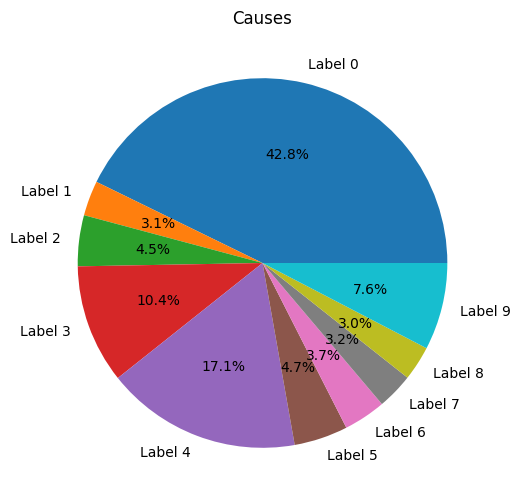

In [24]:
vectorizer = TfidfVectorizer()
stop_words = set(stopwords.words('english'))
stop_words.update(['the','we','cargo','feet','ft','plane', 'aircraft', 'flight','crashed','en','route','sea'])  # Add additional words to remove
stop_words.update(['000','55','miles','ft','000','500','200','mt','rio','de','janeiro'])
df['Summary'] = df['Summary'].apply(lambda x: ' '.join([word for word in word_tokenize(x) if word not in stop_words]))
features = vectorizer.fit_transform(df['Summary'])

# Clustering with the k we decided to use
k = 10  
kmeans = KMeans(n_clusters=k, random_state=42)
kmeans.fit(features)

terms = vectorizer.get_feature_names_out()

# Get top words from each cluster
cluster_keywords = []
order_centroids = kmeans.cluster_centers_.argsort()[:, ::-1]
for i in range(k):
    top_keywords = [terms[ind] for ind in order_centroids[i, :5]]  # Select top 3 words
    cluster_keywords.append(top_keywords)

# Assign labels to clusters based on keywords
cluster_labels = [', '.join(keywords) for keywords in cluster_keywords]


df['Cluster'] = kmeans.labels_
df['Label'] = [cluster_labels[label] for label in kmeans.labels_]
from collections import Counter
all_labels = [cluster_labels[label] for label in kmeans.labels_]

# Occurences of each label
label_counts = Counter(all_labels)
labels = [f"Label {i}" for i in range(k)]
labels = [f"Label {i}" for i in range(10)]
frequencies = list(label_counts.values())
    
# Print the most common labels
most_common_labels = label_counts.most_common()
for label, count in most_common_labels:
    print(f"Label: {label}, Count: {count}")


label_counts = Counter(all_labels)

plt.figure(figsize=(8, 6))
plt.pie(frequencies, labels=labels, autopct='%1.1f%%')
plt.title('Possible causes')
#fig = plt.figure(figsize = (10, 5))
 
# creating the bar plot
#plt.bar(labels, frequencies, 
            #width = 0.4)
 
#plt.xlabel("causes")
#plt.ylabel("Number of cases")
plt.title("Causes")
plt.show()

    # Display the chart
    #plt.show()
    #print(df)

In [92]:
#Before 1950


##preprocessing for data prewar
dfp = df_prewar[['Summary', 'Fatalities']]
dfp = dfp.drop_duplicates()
dfp = dfp.dropna(subset=['Summary', 'Fatalities'])

# Data cleaning and standardization
dfp['Summary'] = dfp['Summary'].str.lower()  # Convert to lowercase
dfp['Summary'] = dfp['Summary'].str.replace(r'[^\w\s]', '')  # Remove punctuation

# Tokenize the text and remove stopwords
stop_words = set(stopwords.words('english'))
stop_words.update(['plane', 'aircraft', 'flight','crashed','en','route','sea','miles','ft','000','500','200','mt'])  # Add additional words to remove
dfp['Summary'] = dfp['Summary'].apply(lambda x: ' '.join([word for word in word_tokenize(x) if word not in stop_words]))

In [1]:
firstlist = ['The aircraft crashed following a fire onboard while en route.', 'The aircraft crashed into hill while attempting to land. Failure to maintain the minimum flight altitude during the final stages of the visual approach.', 'The pilot feathered the right engine for undetermined reasons, failed to maintain safe altitude and crashed into a telephone pole and wires.', 'After diverting to Adana because of pressurization problems, the aircraft hit the ground downwind on the second approach and caught fire.', 'Crashed shortly after leaving Bogota after an explosion aboard.', 'The aircraft struck a mountain in rain and thunderstorms operating as a non-scheduled passenger airliner run by the military.', 'The plane crashed after the detonation of a bomb in the forward cargo hold. A flight attendant,  22 year old Vesna Vulovic, fell 33,330 feet in the tail section and although she broke both legs and was temporarily paralyzed from the waist down, she survived. She was in a coma for 27 days and it took 16 months for her to recover. The bomb was believed to be placed on the plane by a Croatian extremist group. On January 27, 1997, 25 years after the crash, Vesna Vulovireturned to the crash-site and was reunited with the firemen who pulled her from the wreckage and the medical team who looked after her in the hospital.', 'Due to a compass error the aircraft became lost and crashed during a forced landing due to fuel starvation.', 'Crashed while attempting to land. Overloaded', 'Pilot flying too high and suffered hypoxia. Pilot had emphysema and advanced arteriosclerosis. No oxygen aboard the aircraft.', 'Disappeared while en route. Wreckage found 3 days later.', 'Shot down while en route. Aircraft not found.', 'The aircraft failed to maintain flying speed after a engine failure for undetermined reasons. Ice seen on aircraft before and after the accident.', 'In-flight fire caused in-flight structural failure. Left wing separated due to fire resulting from engine cylinder separation. Excessive working hours may have contributed to the accident.', 'Flew into thunderstorm activity and crashed into ocean for reasons unknown. Continued VFR flight into adverse weather conditions.', 'The aircraft was on final approach to Albany County Airport in light snow and two miles visibility, when the pilot reported a malfunctioning left propeller cruise pitch lock. The captain ordered the engine shut down but the crew was unsuccessful in feathering the prop and the plane began to lose altitude. The plane crashed 4 miles short of the runway into a two-family house killing one man. Malfunction of the cruise pitch lock.  Inability of the crew to feather the left propeller, in combination with the descent below the minimum approach altitude. The reason for the malfunction and inability to feather the prop remains undetermined.', 'The aircraft struck a mountain ridge during approach, 50 miles E of Dubai. Incorrect information from an outdated flight plan.', 'The aircraft crashed into Shamsam Mountain and exploded, during a visual approach, 4 miles SW of the airport.', 'The cargo plane crashed.', 'Crashed in mountainous terrain,  50 miles north of Rio de Janeiro, while on approach.', 'Crashed into high ground while en route in thunderstorm activity. Loss of control due to downdrafts and updrafts in thunderstorm activity.', 'Float equipped sightseeing helicopter encountered turbulence which led to the blades flapping and a steep nose down crash into the river.', 'The aircraft broke-up after overrunning the runway and an aborted takeoff. Partial loss of braking power due to the incorrect reassembly and repairs of the braking system.', 'The cargo plane struck a mountain in poor weather conditions. The pilot elected to use a cruising altitude lower than stipulated in order to save time and continue flying in VFR conditions.', 'Hit trees while flying through a mountain pass in rain and fog.', 'Crashed on approach. Windshear.', "The plane cashed into Mt. Lunga during an approach to Palermo. The crew's non-adherence to airport traffiregulations. The aircraft was named Antonio Pigafetta.", 'Struck a mountain while en route.', 'Forward cargo door was not secured, opened in flight. Cargo damaged left propeller. Open door created extra drag. Pilot lost control and crashed.', 'Overshot the runway in heavy fog and crashed into the ocean while landing.', 'Crashed after taking off this North sea island for another island.', 'Crashed into the water after the fatigue failure of both tail rotor blade grips.', 'Cashed into trees shortly after taking off after two engines failed. Refueling directly from the trucks, without allowing sufficient time for the fuel to settle.', "While practicing touch and go landing the aircraft crashed after getting caught in the wake turbulence of a DC-10. An encounter with a trailing vortex generated by a preceding 'heavy' jet which resulted in an involuntary loss of control of the airplane during final approach. Although cautioned to expect turbulence the crew did not have sufficient information to evaluate accurately the hazard or the possible location of the vortex. Existing FAA procedures for controlling VFR flight did not provide the same protection from a vortex encounter as was provided to flights being given radar vectors in either IFR or VFR conditions.", 'Flew into mountain pass in fog. Wing caught ground in turnaround. Continued VFR flight into adverse weather conditions.', 'In flight engine fire caused left wing to separate.', 'Crashed on approach.', 'On approach the aircraft struck El Ovejero mountain.', 'The aircraft crashed short of the runway. Indian officials claimed the crash was caused by a disregard for prescribed procedures in abandoning all instrument references before making visual contact with the runway. Japanese investigators claimed a false glide path signal was responsible for the descent into terrain.', 'The plane crashed while en route from Singapore to Hong Kong. Detonation of an explosive device in the passenger cabin in a suitcase under a seat. A Thai police lieutenant, accused of planting the bomb, was acquitted due to lack of sufficient evidence.', 'Mentally distrubed passenger in rear seat shot pilot twice.', 'Structural failure and separation of both wings due to a fatigue crack in the center wing section.', "The plane crashed into a field shortly after taking off from Heathrow Airport. The airplane stalled after the wing's leading edge devices were retracted prematurely after takeoff.  Failure of the captain to maintain adequate speed after noise abatement procedures. Premature retraction of the slats. Incapacitation of the captain due to a possible arterial hemorrhage.", 'The pilot over-rotated during a go-around from a landing attempt , lost control and crashed. Crew error. The reason for rejecting the landing is not known.', 'Hti wires above creek while surveying flood damage.', 'Both aircraft were proceeding under VFR getting ready to land when there was a midair collision. Both aircraft crashed into Lake Winnebago and sank. The failure of both flightcrews to detect visually the other aircraft in sufficient time to initiate evasive action.', 'The takeoff was aborted and the plane overran the runway and crashed into a camp and caught fire. Elevator gust locks not removed.', 'The aircraft flew into a blind canyon. Stalled and crashed into rising terrain while in a turnaround.', 'Two hijackers and one passenger killed.', 'The plane ditched into the sea, 14 miles from Gran Canana Island.', 'On the takeoff run, a loud explosion was heard and the takeoff was aborted. The aircraft never became airborne,  overran the runway and crashed into shallow water.  On passenger that did not have her seatbelt on was killed.', 'Midair collision. Seventeen aboard the HK-134 and twenty-one aboard the HK-107 killed.', 'Crashed on second approach after the pilot used the wrong flap setting and gears down after initiating a go-around.', 'In cargo bay 6, hot air, leaking from an air conditioning system, melted insulation off cabling causing a short circuit in the stabilizing system. Melting insulation ignited flammable fluid which led to an uncontrollable fire that eventually weakened the structure until the tail fell off.', 'Lost control soon after it took off and crashed into the sea.', 'The aircraft crashed while the crew was returning to the airport after experiencing a No.1 engine failure.', 'The aircraft crashed, trailing heavy smoke. Fire caused by spontaneous ignition of passenger baggage.', 'While on a VFR flight, the aircraft, struck  Mt. Giluwe at  14,346 feet. Cause undetermined.', 'The No.1 engine failed during takeoff, the aircraft banked left, lost height, touched down again and ran through small trees and a fence . The right gear collapsed and the nose hit the ground.', 'Crashed after a wing separated from the fuselage.', "A World War II vintage Sabrejet fighter leaving an air show at Executive Airport was unable to get airborn and crashed into a Farrell's Ice Cream Parlor on Freeport Blvd. Twenty-two people on the ground, including 12 children were killed. The pilot, was pulled from the wreckage by a bystander and survived. The pilot tried to lift off too quickly, pointing the nose of the jet three times higher than the normal angle. Instead of becoming airborne sooner, the plane had trouble getting off the ground.", 'Crashed 23 miles from Saigon while attempting an emergency landing.', 'The student pilot rotated too quickly, the plane stalled and crashed.', 'Shot down by a mortar shell while approaching to land at Kampot.', 'The flight ditched into Black Sea shortly after takeoff. The accident occurred in good weather and visibility, and ground controllers received no distress message prior to the crash. An investigation failed to reveal its cause.', 'Flew into thunderstorm activity and crashed into the ocean. Continued VFR flight into adverse weather conditions.', 'The aircraft crashed at the outer marker while attempting to land for the third time in poor weather conditions.  Sudden incapacitation of the crew for reasons unknown.', "The plane left Montevideo bound for Santiago, Chile carrying the Old Christians Rugby Team. After leaving Mendoza and while flying at FL150, the copilot radioed he was over Curico and requested clearance to FL100. Because of head winds, the plane was actually still over the Andes. As the plane descended into clouds it ran into turbulence and the crew found themselves surrounded by mountains on all sides. The crew tried to climb out but the right wingtip struck the mountainside. The right wing detached and separated from the aircraft taking off part of the tail. The fuselage slid down a mountain slope and came to rest in the Andes mountains at an altitude of 12,000 feet. The survivors were not found until 12/22/72. Eight passengers died in an avalanche on October 30. Survivors resorted to cannibalism to stay alive. The book and movie 'Alive' is based on this accident. The aircraft flew into a rotor zone or mountain wave which led to loss of control of the aircraft.", 'The plane was on a flight from Anchorage to Juneau when it disappeared as it was approaching the Chugach Mountain range.  The weather along the prescribed route was not condusive to VFR flight.  Louisiana Congressman and House Majority Leader Hale Boggs, Alaska Congressman Nick Begich and his aide killed. Cause unknown.', 'Crashed into the sea just short of the runway while on approach in poor visibility.', 'Crashed while landing in severe turbulence. Faulty indication by radio compass.', 'Plummeted to the ground and burst into flames near a farmhouse after losing control with the tower. Visual approach in descent below minima.', 'The crew elected to divert to Plovdiv due to fog. While on approach, the aircraft flew into a mountain.', 'Improperly loaded aircraft, weight and center of gravity.', "The aircraft lost altitude while taking off and crashed. The copilot responded to the captain's 'gear-up' command by reaching forward and pulling back on the ground spoiler handle, rather than lifting the gear handle which was immediately ahead of the spoiler control. Late night partying by the crew was suspected the night before.", 'Lost both engines on final approach. Struck trees and 2 houses. Fuel starvation. Did not refuel in Duluth.', 'Reached a height of 300 feet  when the plane suddenly plunged to earth and crashed. Loss of control precipitated by abnormal maneuvers made by the pilot in command in zero visibility.', 'Crashed after the No. 4 engine separated from the plane.', 'The aircraft entered a spiral, while the captain tried to remove ice from the windscreen with a scraper. This caused a violent correction which led to a high speed stall. The DC-3 crashed  12 miles south of LaRandall in a nose and wing down attitude.', 'Crashed into hilly area in poor weather conditions.', "The aircraft crashed while making a nonprecision instrument approach to Runway 31L. The accident occurred in a residential area approximately 1.5 miles southeast of the approach end of Runway 31L. Upon reaching mimimum descent altitude, the pilot raised the nose of the aircraft to stop the descent. The stall warning horn sounded and continued to sound until the plane crashed 17 seconds later. The aircraft was destroyed by impact and subsequent fire. The captain's failure to exercise positive flight management during the execution of a non-precision approach, which culminated in a critical deterioration of airspeed resulting in a stall from which level flight could no longer be maintained. U.S. Representative from Illinois George Collins killed. Wife of  Watergates E. Howard Hunt, Dorothy Hunt, also killed.", 'The positioning flight failed to climb after takeoff and crashed into a fuel storage tank.', "The Delta Convair, taxing across Runway 27L, after landing in heavy fog, was hit by the North Central DC-9 as it took off, shearing off its tail. The DC-9 came crashing back down on the runway and caught fire. Ten people out of 45 aboard the DC-9 were killed. None of the 88 aboard the Convair were killed. The ATC gave ambiguous instructions to the Delta crew, did not use all available information to determine the location of the CV-880 and the CV-880 crew did not request clarification of the controller's instructions.", 'Crashed on approach into the sea.', 'Hit high ground while on approach to Fornebu Airport in Oslo. Pilot error.', "The crew was preoccupied with a landing gear problem and was trying to replace the landing gear light while on autopilot and in a holding pattern. As the captain got up to help, he inadvertently pushed on the yoke releasing the autopilot. With no ground reference and  under nighttime conditions, the aircraft gradually descended until it crashed into Everglades, 18.7 miles west-northwest of Miami . The failure of the crew to monitor the flight instruments during the final 4 minutes of flight, and to detect a descent soon enough to prevent impact with the ground. After spare parts from the L-1011 were used on other planes, apparitions of the captain, Robert Loft and flight engineer, Don Repo began to be reported by Eastern employees. The book 'The Ghost of Flight 401'and movies 'The Ghost of Flight 401' and 'Crash' are based on this accident. Three passengers and one crew member died in weeks following the accident making the total 103.", 'The flight crashed moments after taking off after losing the No. 2 engine and losing power in the No. 3 engine.  Overloaded by 4,193 lbs.  Inadequate maintenance, inspection and previous damage to the engine during a taxing accident led to the engine failures. Baseball player Roberto Clemente, 38, killed. Clemente was on a relief mission to deliver supplies for earthquake victims in Nicaragua.']

In [3]:
secondlist = ['Crashed into a hill after encountering a fog bank and not climbing in sufficient time to avoid the terrain.', 'Struck a mountain while flying in low clouds and poor visibility.', 'Crashed into San Francisco bay shortly after taking off. The right wing struck to water as the plane made a wide turn.', 'Disappeared en route.', 'The transport crashed into a hillside as it took off in heavy fog at Guildford Airport.', 'Broke-up after entering an area of thunderstorms. Initial structural failure involved the elevator followed by the entire aircraft.', 'Crashed into a hill shortly after taking off from Sorido airstrip. Cause unknown.', 'Flying low because of poor visiblity, the aircraft struck a radar tower, lost its right wing, crashed and burned. Pilot error. Flying VFR in IFR conditions.', 'The aircraft went in to a spin and crashed in a wooded area and caught fire.', 'Crashed into mountains.', 'Disappeared off the Atlanticoast after sending a distress message. A witness observed the plane hit the water at a 45 degree angle. No wreckage or bodies were ever found.', 'Crashed and burned on a hillside after experiencing engine failure.', 'Crashed into a village exploding and destoying several houses.', 'Disappeared on a trans-Atlantiflight from Montreal to England.', 'Crashed shortly after take off into Lake Victoria.', 'After deviating off course 8 miles to avoid military traffic, the two planes collided at 3,000 ft. The commercial pilot landed the plane in a corn field.  Two occupants of the A-26 (33-35553) were killed and one parachuted safely. One infant was killed on the DC-3.  Lack of vigilance on the part  of the pilots of both aircraft, resulting in the failure of each pilot to see the other aircraft in time to  avoid a collision.', 'A U.S. Army Air Force plane crashed into the 79th floor of the Empire State Building in heavy fog.  Lt. Col. William Franklin Smith Jr., the pilot, became disoriented while trying to land at Newark Airport.  Lt. Smith was told he had a 3 hour wait to land at Newark. Impatient to get his plane on the ground, he falsely declared he had official business at La Guardia Airport with the intention of diverting to Newark as soon as he was cleared. The 12 ton plane smashed a 20 ft. hole in the building. Fuel from the ruptured gas tanks poured out and set two floors ablaze killing 10 people. One engine exited the south side of the building and plunged into a penthouse below.  The second engine entered an elevator shaft and severed the cables plunging the car and the elevator operator 1,000 feet into a sub basement. Despite suffering a broken back and legs, she survived.', 'Left Milne Bay on routine flight  to Dobodura at 10:15. Crashed into sea near Milne Bay.', 'Failed to gain altitude while taking off, struck trees, lost both wings, exploded and burned. Engine failure.', 'Cashed and burned shortly after takeoff after experiencing an engine fire in the No. 2 engine.', 'Lost altitude while in a turn and attempting to land and crashed and burned.', 'The aircraft failed to gain speed or altitude and struck a hill at the end of the runway.', 'Struck a radio transmission tower while on approach for landing at Nanyman field.', 'Disappeared en route.', 'Penetrated a thunderstorm and broke-up.', 'Crashed and burned on takeoff striking a hill.  Possible engine failure or overloading.', 'The crew descended through low overcast to obtain their position.  Followed an river and crashed into wooded mountainside.  Navigator error in not informing the pilot of high terrain.', 'Crashed into the Himalaysas and burned while en route.', 'The aircraft expierence a midair collision over Corpus Christi Bay while on a training flight.', 'The pilot radioed he was lost, shortly before impacting the ground while attempting to land in poor visibility.', 'The plane disappeared after the pilot radioed he was exeriencing heavy icing and asked to divert to Rome.  The plane was found 5 months later on Mt. Meta.', 'Crashed and burned after experiencing an engine fire.', 'Crashed into a mountain ridge 200 ft. short of the summit, bounced over the top and crashed down the other side while  en route.', 'Crashed into a 7,000 ft. mountain, 150 feet below the ridge, shortly after taking off.', 'The aircraft crashed into a hill shortly after takeoff after and  making a turn, before reaching the prescribed altitude.', 'Crashed in severe turbulence in thunderstorms after losing the right wing and breaking up.', "The five aircraft, (23307) (73209) (46325) (46094) (45714), flying out of the U.S. Naval Air Station at Fort Lauderdale, on a training mission,  became lost, ran out of fuel and crashed into the AtlantiOcean.  No trace of the planes were ever found. This was the incident that began the 'Bermuda Triangle' legend.", 'Crashed into a field after hitting trees while attempting to land in a snowstorm.', 'Flew into the side of a hill.']

In [6]:
dfwar = pd.DataFrame({"Summary": firstlist})

In [7]:
dfnotwar = pd.DataFrame({"Summary": secondlist})

Label: island, land, attempting, fuel, aboard, Count: 17
Label: approach, visual, mountain, windshear, el, Count: 12
Label: vfr, conditions, weather, thunderstorm, activity, Count: 12
Label: pilot, hit, ground, high, airport, Count: 10
Label: engine, separated, fire, wing, caused, Count: 9
Label: runway, visibility, poor, takeoff, short, Count: 9
Label: lost, control, landing, soon, error, Count: 6
Label: struck, mountain, incorrect, braking, outdated, Count: 4
Label: found, shot, days, wreckage, disappeared, Count: 4
Label: cargo, tail, grips, blade, water, Count: 4


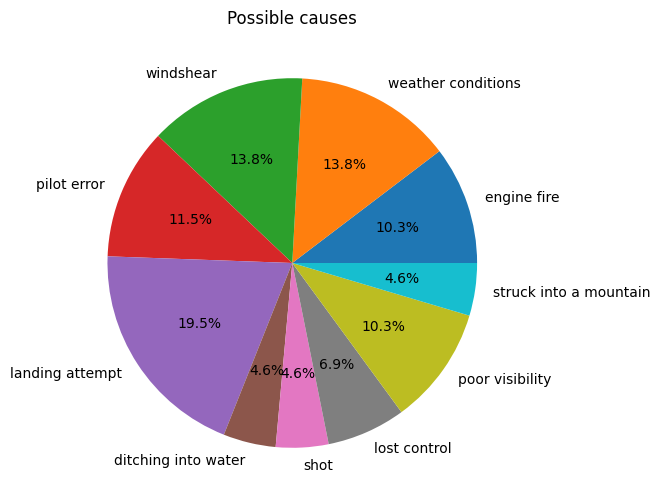

                                              Summary  Cluster  \
0                            following fire onboard .        1   
1   hill attempting land . failure maintain minimu...        9   
2   pilot feathered right engine undetermined reas...        2   
3   diverting adana pressurization problems , hit ...        3   
4           shortly leaving bogota explosion aboard .        0   
..                                                ...      ...   
82  delta convair , taxing across runway 27l , lan...        7   
83                                         approach .        9   
84  hit high ground approach fornebu airport oslo ...        3   
85  crew preoccupied landing gear problem trying r...        8   
86  moments taking losing . 2 engine losing power ...        1   

                                               Label  
0              engine, separated, fire, wing, caused  
1          approach, visual, mountain, windshear, el  
2   vfr, conditions, weather, thunderstorm

In [16]:
#same algorithm but df is df pre-war

dfp = dfwar
##Kmeans for data prewar
dfp = dfp.drop_duplicates()
dfp = dfp.dropna(subset=['Summary'])

    # Data cleaning and standardization
dfp['Summary'] = dfp['Summary'].str.lower()  # Convert to lowercase
dfp['Summary'] = dfp['Summary'].str.replace(r'[^\w\s]', '')  # Remove punctuation

    # Tokenize the text and remove stopwords
stop_words = set(stopwords.words('english'))
stop_words.update(['plane', 'aircraft', 'flight','crashed','en','route','sea','miles','ft','000','500','200','mt'])  # Add additional words to remove
dfp['Summary'] = dfp['Summary'].apply(lambda x: ' '.join([word for word in word_tokenize(x) if word not in stop_words]))
vectorizer = TfidfVectorizer()
features = vectorizer.fit_transform(dfp['Summary'])
k = 10
kmeans = KMeans(n_clusters=k, random_state=42)
kmeans.fit(features)

terms = vectorizer.get_feature_names_out()

cluster_keywords = []
order_centroids = kmeans.cluster_centers_.argsort()[:, ::-1]
for i in range(k):
    top_keywords = [terms[ind] for ind in order_centroids[i, :5]]  # Select top 3 words
    cluster_keywords.append(top_keywords)

cluster_labels = [', '.join(keywords) for keywords in cluster_keywords]

dfp['Cluster'] = kmeans.labels_
dfp['Label'] = [cluster_labels[label] for label in kmeans.labels_]
from collections import Counter
all_labels = [cluster_labels[label] for label in kmeans.labels_]

# Count the occurrences of each label
label_counts = Counter(all_labels)

# Print the most common labels and their frequencies
most_common_labels = label_counts.most_common()
for label, count in most_common_labels:
    print(f"Label: {label}, Count: {count}")

# Count the occurrences of each label
label_counts = Counter(all_labels)

# Get the labels and their frequencies
labels = [f"Label {i}" for i in range(k)]
labels = ["engine fire","weather conditions", "windshear","pilot error","landing attempt","ditching into water","shot", "lost control", "poor visibility","struck into a mountain" ]
frequencies = list(label_counts.values())

# Create the pie chart
plt.figure(figsize=(8, 6))
plt.pie(frequencies, labels=labels, autopct='%1.1f%%')
plt.title('Possible causes')

# Display the chart
plt.show()
print(dfp)

Label: shot, air, fire, pilot, killed, Count: 2064
Label: approach, pilot, terrain, altitude, ground, Count: 825
Label: engine, failure, landing, fire, emergency, Count: 502
Label: runway, short, approach, landing, overran, Count: 368
Label: taking, shortly, minutes, engine, airport, Count: 227
Label: attempting, land, landing, runway, struck, Count: 215
Label: conditions, weather, vfr, adverse, continued, Count: 178
Label: takeoff, engine, shortly, failure, runway, Count: 153
Label: turbulence, thunderstorm, severe, wing, area, Count: 148
Label: mountain, struck, flew, poor, weather, Count: 146


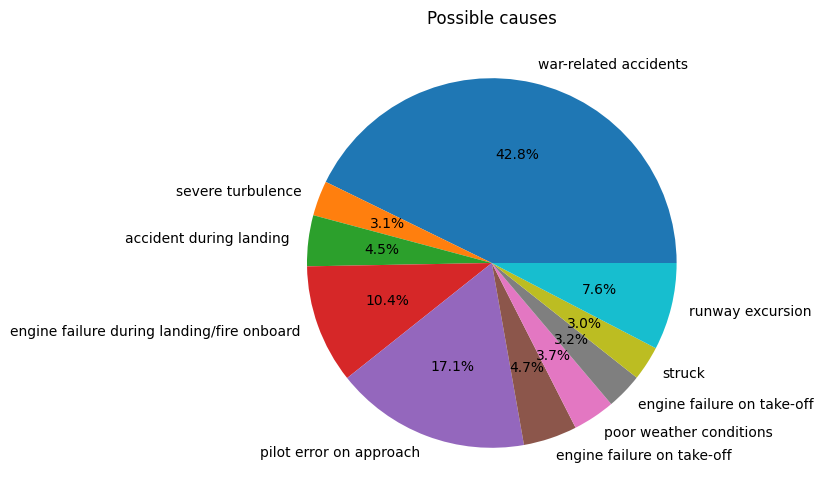

                                                Summary  Fatalities  Cluster  \
0     demonstration , u.s. army flyer flown orville ...         1.0        2   
1     first u.s. dirigible akron exploded offshore a...         5.0        2   
2     first fatal airplane accident canada occurred ...         1.0        2   
3     airship flew thunderstorm encountered severe d...        14.0        3   
4     hydrogen gas vented sucked forward engine igni...        30.0        2   
...                                                 ...         ...      ...   
5263  approach , military transport 4 houses , skidd...        98.0        2   
5264                    approach isiro-matari airport .         4.0        4   
5265  airbus went missing atlantiocean paris , franc...       228.0        2   
5266  air ambulance hills attempting land heavy fog ...         1.0        1   
5267  military transport went missing might due heav...        13.0        2   

                                       

In [95]:
vectorizer = TfidfVectorizer()

stop_words = set(stopwords.words('english'))
stop_words.update(['cargo','feet','ft','plane', 'aircraft', 'flight','crashed','en','route','sea'])  # Add additional words to remove
stop_words.update(['000','55','miles','ft','000','500','200','mt','rio','de','janeiro'])
df['Summary'] = df['Summary'].apply(lambda x: ' '.join([word for word in word_tokenize(x) if word not in stop_words]))


features = vectorizer.fit_transform(df['Summary'])


k = 10 
kmeans = KMeans(n_clusters=k, random_state=42)
kmeans.fit(features)
terms = vectorizer.get_feature_names_out()


cluster_keywords = []
order_centroids = kmeans.cluster_centers_.argsort()[:, ::-1]
for i in range(k):
    top_keywords = [terms[ind] for ind in order_centroids[i, :5]]  # Select top 3 words
    cluster_keywords.append(top_keywords)


cluster_labels = [', '.join(keywords) for keywords in cluster_keywords]


df['Cluster'] = kmeans.labels_
df['Label'] = [cluster_labels[label] for label in kmeans.labels_]

# Print the resulting clusters with labels
#print(df)


from collections import Counter

# Print the resulting cluster labels
#for label in kmeans.labels_:
#    print(cluster_labels[label])


all_labels = [cluster_labels[label] for label in kmeans.labels_]
label_counts = Counter(all_labels)

most_common_labels = label_counts.most_common()
for label, count in most_common_labels:
    print(f"Label: {label}, Count: {count}")


label_counts = Counter(all_labels)

labels = [f"Label {i}" for i in range(k)]
labels = ["war-related accidents","severe turbulence", "accident during landing","engine failure during landing/fire onboard","pilot error on approach","engine failure on take-off","poor weather conditions", "engine failure on take-off", "struck","runway excursion" ]
frequencies = list(label_counts.values())


plt.figure(figsize=(8, 6))
plt.pie(frequencies, labels=labels, autopct='%1.1f%%')
plt.title('Possible causes')


plt.show()
print(df)

#label_text = ' '.join(all_labels)
#tokens = label_text.split()
#word_counts = Counter(tokens)

# Print the most common words
#most_common_words = word_counts.most_common()
#for word, count in most_common_words:
#    print(f"Word: {word}, Count: {count}")

Text(0.5, 1.0, 'Possible causes')

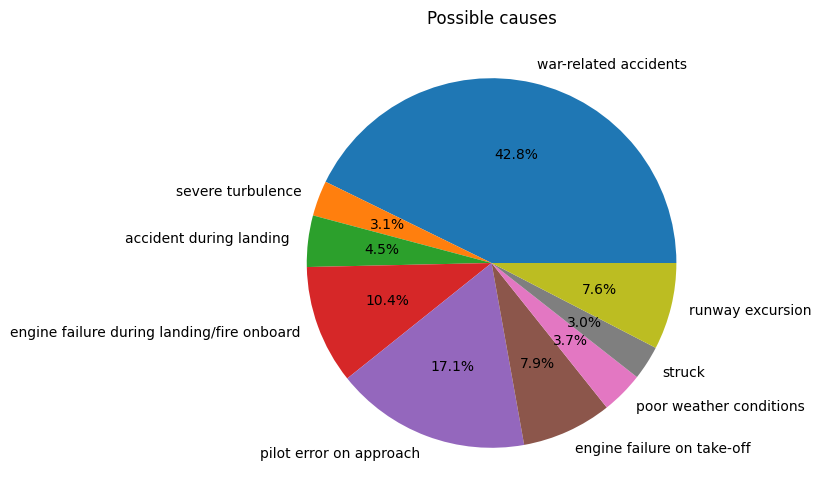

In [24]:
labels2 = ["war-related accidents","severe turbulence", "accident during landing","engine failure during landing/fire onboard","pilot error on approach","engine failure on take-off","poor weather conditions", "struck","runway excursion" ]

frequencies2 = [42.8,3.1,4.5,10.4,17.1,7.9,3.7,3.0,7.6]

plt.figure(figsize=(8, 6))
plt.pie(frequencies2, labels=labels2, autopct='%1.1f%%')
plt.title('Possible causes')

In [ ]:

from sklearn.decomposition import LatentDirichletAllocation, NMF
from sklearn.feature_extraction.text import TfidfVectorizer, ENGLISH_STOP_WORDS
from gensim.models import CoherenceModel
from gensim import corpora
from gensim.models import LdaModel, Nmf

Number of topics:  10
LDA Coherence Score: 0.42037011840642524
NMF Coherence Score: 0.5158711446612723
Number of topics:  11
LDA Coherence Score: 0.3959860385680392
NMF Coherence Score: 0.5029470913287994
Number of topics:  12
LDA Coherence Score: 0.3949636295374431
NMF Coherence Score: 0.5037825229531235
Number of topics:  13
LDA Coherence Score: 0.4002575804630349
NMF Coherence Score: 0.4792906122109659
Number of topics:  14
LDA Coherence Score: 0.4156621486755486
NMF Coherence Score: 0.48077860342194156
Number of topics:  15
LDA Coherence Score: 0.4050385538033768
NMF Coherence Score: 0.48957155027556615
Number of topics:  16
LDA Coherence Score: 0.4085298515776845
NMF Coherence Score: 0.47133791020369065
Number of topics:  17
LDA Coherence Score: 0.4107056632385664
NMF Coherence Score: 0.4631298887702745
Number of topics:  18
LDA Coherence Score: 0.40322670208980105
NMF Coherence Score: 0.4692007580840412
Number of topics:  19
LDA Coherence Score: 0.4097245267270756
NMF Coherence S

/Users/zlatastefanovic/myenv/lib/python3.12/site-packages/sklearn/decomposition/_nmf.py:1770: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


Number of topics:  33
LDA Coherence Score: 0.40249875217092546
NMF Coherence Score: 0.424135808508516
Number of topics:  34
LDA Coherence Score: 0.40754983285013047
NMF Coherence Score: 0.43110045166124583
Number of topics:  35
LDA Coherence Score: 0.4056711215057896
NMF Coherence Score: 0.4399614397097891
Number of topics:  36
LDA Coherence Score: 0.4089346101238214
NMF Coherence Score: 0.4268526779507993
Number of topics:  37
LDA Coherence Score: 0.39307404557647313
NMF Coherence Score: 0.42069511281734095
Number of topics:  38
LDA Coherence Score: 0.4019009898011819
NMF Coherence Score: 0.4103540316704047
Number of topics:  39
LDA Coherence Score: 0.40689355837189906
NMF Coherence Score: 0.4386112453115663
Number of topics:  40
LDA Coherence Score: 0.38212820817882287
NMF Coherence Score: 0.4306793944914011
Number of topics:  41
LDA Coherence Score: 0.38373071303301026
NMF Coherence Score: 0.43216304493964325
Number of topics:  42
LDA Coherence Score: 0.41879808946083974
NMF Coheren

/Users/zlatastefanovic/myenv/lib/python3.12/site-packages/sklearn/decomposition/_nmf.py:1770: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


Number of topics:  94
LDA Coherence Score: 0.3450264657593319
NMF Coherence Score: 0.40377937788890006
Number of topics:  95
LDA Coherence Score: 0.35863823092545977
NMF Coherence Score: 0.39754195083595795
Number of topics:  96
LDA Coherence Score: 0.35415143317465186
NMF Coherence Score: 0.3754372048853165
Number of topics:  97
LDA Coherence Score: 0.355679249421441
NMF Coherence Score: 0.38336691540448714
Number of topics:  98
LDA Coherence Score: 0.35030076340649147
NMF Coherence Score: 0.3829682123308751
Number of topics:  99
LDA Coherence Score: 0.36032323107937403
NMF Coherence Score: 0.3905455472884964


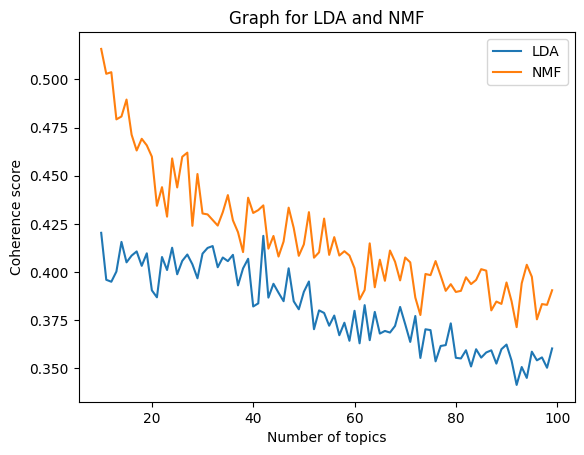

In [6]:
#Defining the optimal number of topics for LDA and NMF
summaries = df['Summary']

lda_coherence_scores = []
nmf_coherence_scores = []
additional_words = ['plane', 'aircraft', 'flight','crashed','en','route','sea','miles','ft','000','500','200','mt','cargo','later','bogota','afghan']  # Add additional words to remove

all_stop_words = list(ENGLISH_STOP_WORDS)+additional_words
vectorizer = TfidfVectorizer(stop_words=all_stop_words)

tfidf_matrix = vectorizer.fit_transform(summaries)
n = 100
for num_topics in range(10,n):

    lda = LatentDirichletAllocation(n_components=num_topics, random_state=42)
    lda.fit(tfidf_matrix)

    nmf = NMF(n_components=num_topics, random_state=42)
    nmf.fit(tfidf_matrix)

    def get_top_words(model, feature_names, n_top_words):
        top_words = []
        for topic_idx, topic in enumerate(model.components_):
            topic_words = [feature_names[i] for i in topic.argsort()[:-n_top_words - 1:-1]]
            top_words.append(topic_words)
        return top_words

    feature_names = vectorizer.get_feature_names_out()
    lda_top_words = get_top_words(lda, feature_names, n_top_words=5)

    nmf_top_words = get_top_words(nmf, feature_names, n_top_words=5)
    print("Number of topics: ",num_topics)
    #for topic_idx in range(num_topics):
        #print(f"Topic {topic_idx + 1} (LDA):", ", ".join(lda_top_words[topic_idx]))
        #print()

    #for topic_idx in range(num_topics):
     #   print(f"Topic {topic_idx + 1} (NMF):", ", ".join(nmf_top_words[topic_idx]))
      #  print()


    tokenized_summaries = [summary.split() for summary in summaries]
    dictionary = corpora.Dictionary(tokenized_summaries)
    corpus = [dictionary.doc2bow(tokens) for tokens in tokenized_summaries]


    lda_model = LdaModel(corpus=corpus, id2word=dictionary, num_topics=num_topics, random_state=42)
    lda_coherence_model = CoherenceModel(model=lda_model, texts=tokenized_summaries, dictionary=dictionary, coherence='c_v')
    lda_coherence = lda_coherence_model.get_coherence()

    nmf_model = Nmf(corpus=corpus, id2word=dictionary, num_topics=num_topics, random_state=42)
    nmf_coherence_model = CoherenceModel(model=nmf_model, texts=tokenized_summaries, dictionary=dictionary, coherence='c_v')
    nmf_coherence = nmf_coherence_model.get_coherence()

    print("LDA Coherence Score:", lda_coherence)
    lda_coherence_scores.append(lda_coherence)
    print("NMF Coherence Score:", nmf_coherence)
    nmf_coherence_scores.append(nmf_coherence)

plt.plot([i for i in range(10,n)], lda_coherence_scores, label='LDA')
plt.plot([i for i in range(10,n)], nmf_coherence_scores, label='NMF')

plt.xlabel('Number of topics')
plt.ylabel('Coherence score')
plt.title('Graph for LDA and NMF')
plt.show()


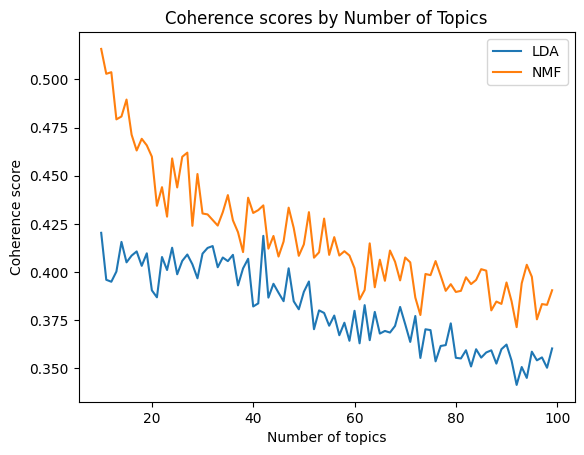

In [8]:
topics = [i for i in range(10,100)]
plt.plot(topics, lda_coherence_scores, label='LDA')
plt.plot(topics, nmf_coherence_scores, label='NMF')
sum = [nmf_coherence_scores[i]+lda_coherence_scores[i] for i in range(0,15)]
#plt.plot(topics,sum, label = 'SUM') #seeing the sum of the coherence scores

plt.xlabel('Number of topics')
plt.ylabel('Coherence score')
plt.title('Coherence scores by Number of Topics')
plt.legend()

plt.show()
##LDA works best for 11 different topics
##NMF works best for 10 different topics

In [31]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation, NMF
from sklearn.feature_extraction.text import TfidfVectorizer, ENGLISH_STOP_WORDS
from gensim.models import CoherenceModel
from gensim import corpora
from gensim.models import LdaModel, Nmf


summaries = df['Summary']

lda_coherence_scores = []
additional_words = ['plane', 'aircraft', 'flight','francisco','mediterranean','crashed','en','route','sea','miles','ft','000','500','200','mt','cargo','later','bogota','afghan']  # Add additional words to remove

all_stop_words = list(ENGLISH_STOP_WORDS)+additional_words
vectorizer = TfidfVectorizer(stop_words=all_stop_words)

num_topics = 10
tfidf_matrix = vectorizer.fit_transform(summaries)
lda = LatentDirichletAllocation(n_components=num_topics, random_state=42)
lda.fit(tfidf_matrix)

def get_top_words(model, feature_names, n_top_words):
    top_words = []
    for topic_idx, topic in enumerate(model.components_):
        topic_words = [feature_names[i] for i in topic.argsort()[:-n_top_words - 1:-1]]
        top_words.append(topic_words)
    return top_words

feature_names = vectorizer.get_feature_names_out()

lda_top_words = get_top_words(lda, feature_names, n_top_words=5)

print("Number of topics: ",num_topics)
for topic_idx in range(num_topics):
    print(f"Topic {topic_idx + 1} (LDA):", ", ".join(lda_top_words[topic_idx]))
    print()
tokenized_summaries = [summary.split() for summary in summaries]

dictionary = corpora.Dictionary(tokenized_summaries)
tokenized_summaries = [summary.split() for summary in summaries]

dictionary = corpora.Dictionary(tokenized_summaries)

corpus = [dictionary.doc2bow(tokens) for tokens in tokenized_summaries]

lda_model = LdaModel(corpus=corpus, id2word=dictionary, num_topics=num_topics, random_state=42)
lda_coherence_model = CoherenceModel(model=lda_model, texts=tokenized_summaries, dictionary=dictionary, coherence='c_v')
lda_coherence = lda_coherence_model.get_coherence()


print("LDA Coherence Score:", lda_coherence)


Number of topics:  10
Topic 1 (LDA): runway, landing, short, engine, attempting

Topic 2 (LDA): weather, conditions, mountain, approach, pilot

Topic 3 (LDA): exploded, landing, air, mid, control

Topic 4 (LDA): thunderstorm, helicopter, rotor, takeoff, windshear

Topic 5 (LDA): engine, takeoff, failure, taking, shortly

Topic 6 (LDA): mail, storm, cause, undetermined, failure

Topic 7 (LDA): crew, icing, gain, engine, approach

Topic 8 (LDA): fuel, collision, engine, midair, aboard

Topic 9 (LDA): rainstorm, attempt, landing, nosed, mountain

Topic 10 (LDA): mountain, shot, approach, struck, ocean

LDA Coherence Score: 0.4090432804341354


In [43]:
nmf_coherence_scores = []
additional_words = ['plane', 'aircraft', 'flight','crashed','en','route','sea','miles','ft','000','500','200','mt','cargo','later','bogota','afghan']  # Add additional words to remove

all_stop_words = list(ENGLISH_STOP_WORDS)+additional_words
vectorizer = TfidfVectorizer(stop_words=all_stop_words)


num_topics = 11
tfidf_matrix = vectorizer.fit_transform(summaries)
nmf = NMF(n_components=num_topics, random_state=42)
nmf.fit(tfidf_matrix)
def get_top_words(model, feature_names, n_top_words):
    top_words = []
    for topic_idx, topic in enumerate(model.components_):
        topic_words = [feature_names[i] for i in topic.argsort()[:-n_top_words - 1:-1]]
        top_words.append(topic_words)
    return top_words

feature_names = vectorizer.get_feature_names_out()
nmf_top_words = get_top_words(nmf, feature_names, n_top_words=5)

print("Number of topics: ",num_topics)
for topic_idx in range(num_topics):
    print(f"Topic {topic_idx + 1} (NMF):", ", ".join(nmf_top_words[topic_idx]))
    print()

tokenized_summaries = [summary.split() for summary in summaries]
dictionary = corpora.Dictionary(tokenized_summaries)
tokenized_summaries = [summary.split() for summary in summaries]

dictionary = corpora.Dictionary(tokenized_summaries)

corpus = [dictionary.doc2bow(tokens) for tokens in tokenized_summaries]
nmf_model = Nmf(corpus=corpus, id2word=dictionary, num_topics=num_topics, random_state=42)
nmf_coherence_model = CoherenceModel(model=nmf_model, texts=tokenized_summaries, dictionary=dictionary, coherence='c_v')
nmf_coherence = nmf_coherence_model.get_coherence()

# Print the topic coherence scores
print("NMF Coherence Score:", nmf_coherence)


Number of topics:  11
Topic 1 (NMF): engine, failure, lost, experiencing, right

Topic 2 (NMF): mountain, flew, struck, fog, hit

Topic 3 (NMF): takeoff, shortly, aborted, stalled, overloaded

Topic 4 (NMF): conditions, vfr, adverse, weather, continued

Topic 5 (NMF): approach, final, crew, pilot, descent

Topic 6 (NMF): attempting, land, fog, burned, airport

Topic 7 (NMF): taking, shortly, minutes, airport, lost

Topic 8 (NMF): runway, short, overran, fog, hit

Topic 9 (NMF): poor, weather, conditions, visibility, conditons

Topic 10 (NMF): landing, emergency, attempt, make, gear

Topic 11 (NMF): struck, ground, high, trees, wing

NMF Coherence Score: 0.5208410779154948


In [45]:
#getting the number of occurences of each topic (with that topic being the most significant one)

document_topic_distribution = nmf_model.get_document_topics(corpus)

topic_indices = []
for doc_topics in document_topic_distribution:
    if doc_topics:
        topic_indices.append(max(doc_topics, key=lambda x: x[1])[0])

topic_counts = Counter(topic_indices)

print("Topic Counts:")
for topic, count in topic_counts.items():
    print(f"Topic {topic + 1}: {count}")

Topic Counts:
Topic 1: 235
Topic 7: 1290
Topic 8: 222
Topic 10: 776
Topic 11: 188
Topic 2: 632
Topic 5: 555
Topic 3: 257
Topic 6: 117
Topic 4: 320
Topic 9: 232


In [41]:
import pandas as pd
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS, TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from gensim import corpora
from gensim.models import LdaModel

document_topic_distribution = lda_model.get_document_topics(corpus)
dominant_topics = [max(topics, key=lambda x: x[1])[0] for topics in document_topic_distribution]

df_document_topic = pd.DataFrame({'Summary': summaries, 'Dominant Topic': dominant_topics})

print(df_document_topic)

df_document_topic.to_csv('document_topic_mapping.csv', index=False)
from collections import Counter
document_topic_distribution = lda_model.get_document_topics(corpus)

topic_indices = [max(topics, key=lambda x: x[1])[0] for topics in document_topic_distribution]

topic_counts = Counter(topic_indices)

print("Topic Counts:")
for topic, count in topic_counts.items():
    print(f"Topic {topic + 1}: {count}")

                                                Summary  Dominant Topic
0     demonstration , u.s. army flyer flown orville ...               3
1     first u.s. dirigible akron exploded offshore a...               1
2     first fatal airplane accident canada occurred ...               9
3     airship flew thunderstorm encountered severe d...               3
4     hydrogen gas vented sucked forward engine igni...               6
...                                                 ...             ...
5263  approach , military transport 4 houses , skidd...               9
5264                    approach isiro-matari airport .               1
5265  airbus went missing atlantiocean paris , franc...               3
5266  air ambulance hills attempting land heavy fog ...               0
5267  military transport went missing might due heav...               7

[4826 rows x 2 columns]
Topic Counts:
Topic 4: 1312
Topic 2: 824
Topic 10: 995
Topic 7: 56
Topic 9: 415
Topic 8: 721
Topic 3: 159
Topic

In [108]:
#calculating coherence scores
#ended up using a different code
from sklearn.metrics.pairwise import cosine_similarity
from itertools import combinations
import numpy as np

def calculate_topic_coherence(top_words):
    coherence_scores = []
    for word_list in top_words:
        pairs = list(combinations(word_list, 2))
        pairwise_similarity = []
        for pair in pairs:
            pair_similarity = cosine_similarity(tfidf_matrix[:, vectorizer.vocabulary_[pair[0]]],
                                                tfidf_matrix[:, vectorizer.vocabulary_[pair[1]]])
            pairwise_similarity.append(pair_similarity[0][0])
        coherence_score = np.mean(pairwise_similarity)
        coherence_scores.append(coherence_score)
    return coherence_scores

lda_coherence_scores = calculate_topic_coherence(lda_top_words)
nmf_coherence_scores = calculate_topic_coherence(nmf_top_words)

for topic_idx, coherence_score in enumerate(lda_coherence_scores):
    print(f"Topic {topic_idx + 1} (LDA) coherence score:", coherence_score)
    print()

for topic_idx, coherence_score in enumerate(nmf_coherence_scores):
    print(f"Topic {topic_idx + 1} (NMF) coherence score:", coherence_score)
    print()

Topic 1 (LDA) coherence score: 0.0

Topic 2 (LDA) coherence score: 0.0

Topic 3 (LDA) coherence score: 0.0

Topic 4 (LDA) coherence score: 0.0

Topic 5 (LDA) coherence score: 0.0

Topic 1 (NMF) coherence score: 0.0

Topic 2 (NMF) coherence score: 0.0

Topic 3 (NMF) coherence score: 0.0

Topic 4 (NMF) coherence score: 0.0

Topic 5 (NMF) coherence score: 0.0

